# Koppen Climate Categorization
- goals write code that takes in the following variables and produces an xarray dataset with each region identified for use with multiple data sources


"A Köppen classification scheme identifies generic vegetation types associated with regional climate zones defined by characteristics of the annual cycles of T and P" [Phillips and Bonfils 2015](https://iopscience.iop.org/article/10.1088/1748-9326/10/6/064005)

Using [Gnanadesikan and Stouffer (2006)](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2006GL028098?src=getftr) scheme that defines 14 climate types.


If we want to do the 30 climate types, [Peel et al. (2007)](https://hess.copernicus.org/articles/11/1633/2007/hess-11-1633-2007.pdf) has a good figure.

## Necessary packages

In [1]:
# data analysis
import numpy as np
import pandas as pd
import xarray as xr
import dask 

import glob

# plotting
import regionmask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from matplotlib import pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

### Functions

In [2]:
def region_select(ds, region_codes):
    """ 
    region codes are defined by the regionmask package. more information is available in their documentation:
    https://regionmask.readthedocs.io/en/stable/defined_scientific.html
    
    region_codes: [list, of, region, codes]
    """ 
    ar6_region = regionmask.defined_regions.ar6.all
    mask = regionmask.defined_regions.ar6.all.mask(ds)
    ds_select = ds.where(xr.concat([mask == ar6_region.map_keys(region) for region in region_codes], dim='comp').max('comp'), drop = True)
    
    return ds_select  

### GLOBAL MEANS ###

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} - {'month'}
    return (ds * weight).mean(other_dims)

### Process Raw Data

In [3]:
project_prefix = '/Users/miriam/Documents/02_academia/02_PhD/research'

fname_prefix = '/raw_data/MERRA-2/land_surface_daily_global/MERRA2_'

fnames = glob.glob(project_prefix + fname_prefix + '*')

ds = xr.open_mfdataset(fnames)


I'm using the ar6 regional selections to grab some regions just to keep the areas easily defined/sensible

In [4]:
regional_ds = region_select(ds, [3, 4, 6])

In [5]:
ar6_selected_regions = regionmask.defined_regions.ar6.all[[3, 4, 6]]

In [6]:
ar6_selected_regions

<regionmask.Regions>
Name:     AR6 reference regions
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)
overlap:  False

Regions:
3 WNA   W.North-America
4 CNA   C.North-America
6 NCA N.Central-America

[3 regions]

<GeoAxesSubplot:xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

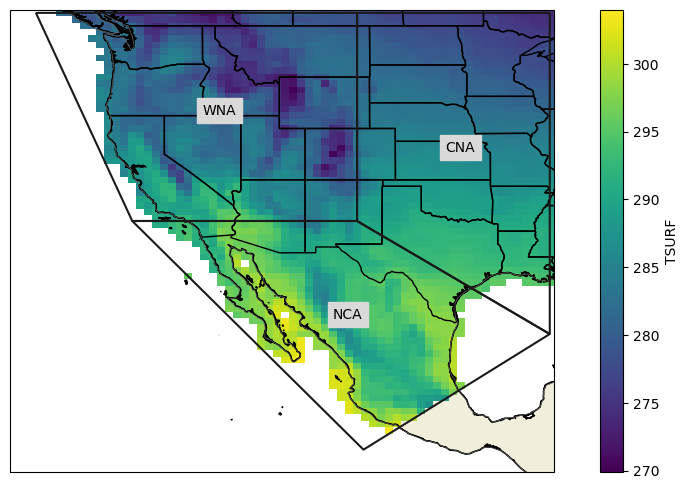

In [7]:
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())

regional_ds.TSURF.mean(dim = 'time').plot(transform=ccrs.PlateCarree())

ax.coastlines('10m')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

ar6_selected_regions.plot(label="abbrev")

### Define Koppen Types using [Gnanadesikan and Stouffer (2006)](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2006GL028098?src=getftr) scheme that defines 14 climate types.

A-types:
- Af: (Tropical wet)   Tmin > 18C, not BS or BW, Pmin > 6
- Am: (Tropical moist) Tmin > 18C, not BS or BW, 6 > Pmin > (250 - Pyear)/25
- Aw: (Tropical dry)   Tmin > 18C, not BS or BW, 6, (250 - Pyear)/25 > Pmin

B-types:
- Bs: (Semiarid) 2(Tave + Poff) > Pyear > (Tave + Poff); 
    - Poff = 0, > 30% of rain in winter 
    - Poff = 7, no wet season
    - Poff = 14, > 30% of rain in summer
- Bw: (Desert) (Tave + Poff) > Pyear

C-types:
- Cs: (Temperate winter wet)  18C > Tmin > 3C ; not BS or BW ; Pmax > 3Pmin, winter max., summer min
- Cfa: (Hot temperate moist)  18C > Tmin > 3C ; not BS or BW ; Not Cs or Cw ; Tmax > 22C
- Cfb: (Warm temperate moist) 18C > Tmin > 3C ; not BS or BW ; Not Cs or Cw ; Tmax < 22C ; 4+ months warmer than 10C
- Cfc: (Cool temperate moist) 18C > Tmin > 3C ; not BS or BW ; Not Cs or Cw ; Tmax < 22C ; Less than 4 months warmer than 10C
- Cw: (Temperate summer wet)  18C > Tmin > 3C ; not BS or BW ; Pmax> 10Pmin, summer max., winter min.

D-types:
- Dab (Cold winters/warm summers) Tmax > 10C, 3C > Tmin, not BS or BW, 4+ months warmer than 10C
- Dc (Cold winters/cool summers) -3C > Tmin, not BS or BW, 4+ months warmer than 10C

E-types:
- Et (Tundra) 10C > Tmax> 0C, Tmin < 3C
- Ef (Polar desert) Tmax < 0

#### Notes:
Tmin, max, ave are the minimum monthly, maximum monthly, and annual-average temperature in C.

Pmin, max, year are the minimum monthly, maximum monthly, and annually-integrated precipitation in cm.



In [8]:
%time ds = regional_ds.load()


CPU times: user 1h 2min 1s, sys: 2min 9s, total: 1h 4min 10s
Wall time: 1h 3min 32s


In [11]:
def g_and_s_types(ds):
    
    return types_ds

In [12]:
t_var = 'TSURF'
p_var = 'PRECTOTLAND'

In [17]:
Tave = ds.mean(dim = 'time')[t_var] - 273.15

monthly_means = ds.groupby('time.month').mean()

Tmin = monthly_means.min(dim = 'month')[t_var] - 273.15
Tmax = monthly_means.max(dim = 'month')[t_var] - 273.15

Pmin = monthly_means.min(dim = 'month')[p_var] * 8640
Pmax = monthly_means.max(dim = 'month')[p_var] * 8640

P_winter_max = monthly_means.sel(month = [12, 1, 2]).max(dim = 'month')[p_var] * 8640
P_winter_min = monthly_means.sel(month = [12, 1, 2]).min(dim = 'month')[p_var] * 8640

P_summer_max = monthly_means.sel(month = [6, 7, 8]).max(dim = 'month')[p_var] * 8640
P_summer_min = monthly_means.sel(month = [6, 7, 8]).min(dim = 'month')[p_var] * 8640

Pyear = ds.groupby('time.year').sum()[p_var].mean(dim = 'year') * 8640

ds_Poff = ds.copy()

ds_Poff['Poff'] = xr.ones_like(ds_Poff[p_var].isel(time = 0))*np.nan

#Poff = 0, > 30% of rain in winter 
ds_Poff['Poff'] = ds_Poff['Poff'].where(~(ds_Poff.isel(time = (ds.time.dt.season == 'DJF'))[p_var].sum(dim = 'time') > (0.3 * ds_Poff[p_var].sum(dim = 'time'))), 0)

#Poff = 14, > 30% of rain in summer
ds_Poff['Poff'] = ds_Poff['Poff'].where(~(ds_Poff.isel(time = (ds.time.dt.season == 'JJA'))[p_var].sum(dim = 'time') > (0.3 * ds_Poff[p_var].sum(dim = 'time'))), 14)

#Poff = 7, no wet season (defining this as everywhere else?)
ds_Poff['Poff'] = ds_Poff['Poff'].where(~((ds_Poff.isel(time = (ds.time.dt.season == 'DJF'))[p_var].sum(dim = 'time') < (0.3 * ds_Poff[p_var].sum(dim = 'time'))) 
                                        & (ds_Poff.isel(time = (ds.time.dt.season == 'JJA'))[p_var].sum(dim = 'time') < (0.3 * ds_Poff[p_var].sum(dim = 'time')))), 7)

four_plus_warm10 = monthly_means.where((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') > 4).mean(dim = 'month')
four_plus_cold10 = monthly_means.where((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') <= 4).mean(dim = 'month')


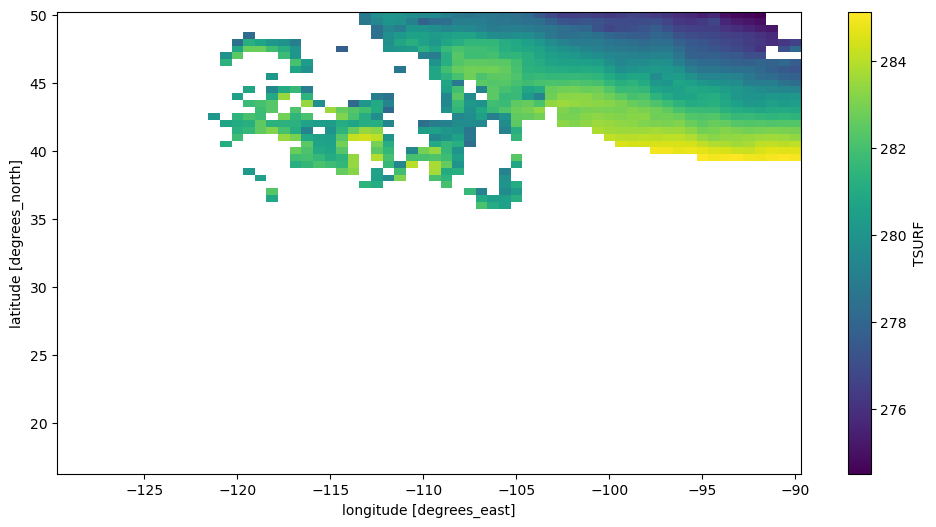

In [18]:
ds.where((Tmax > 10) & (Tmin < -3) & ((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') > 4)).TSURF.mean(dim = 'time').plot()

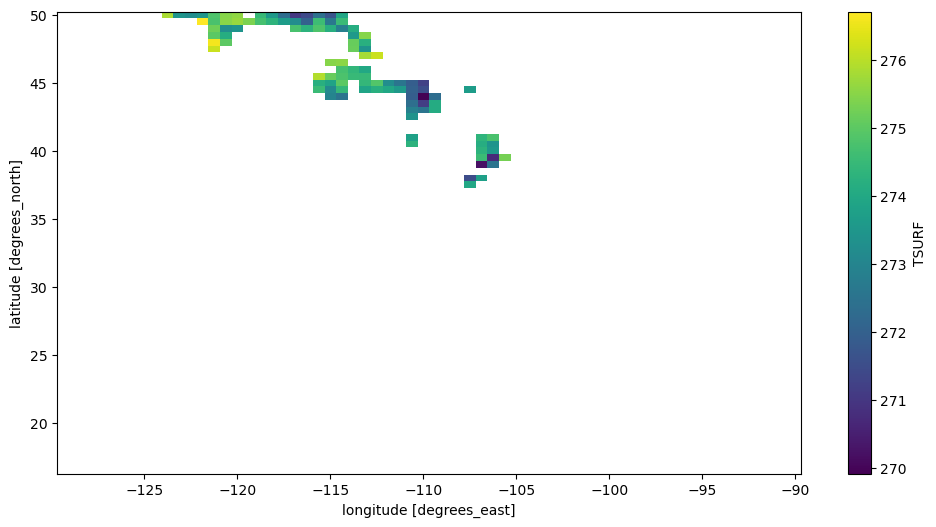

In [19]:
ds.where((Tmin < -3) & ((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') < 4)).TSURF.mean(dim = 'time').plot()

In [20]:
ds_koppen = ds.copy()
ds_koppen['koppen'] = xr.ones_like(ds_koppen[p_var].isel(time = 0))*np.nan
#ds_test['koppen'] = ds_test['koppen'].astype(object)

### A TYPES ###
### COOLEST MONTH WARMER THAN 18C
# Af
ds_koppen['koppen'] = ds_koppen['koppen'].where( ~((Tmin > 18) & (Pmin > 6) &
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Af')

# Am
ds_koppen['koppen'] = ds_koppen['koppen'].where( ~((Tmin > 18) & (Pmin < 6) & (Pmin > ((250 - Pyear)/25)) & 
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Am')


# Aw
ds_koppen['koppen'] = ds_koppen['koppen'].where( ~((Tmin > 18) & (Pmin < ((250 - Pyear)/25)) & (Pmin < 6) &
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Aw')


### B TYPES ###
### ARID - INSEFFICIENT PRECIPITATION TO BALANCE POTENTIAL EVAPORATION
# BS: (Semiarid) 2(Tave + Poff) > Pyear > (Tave + Poff); 
ds_koppen['koppen'] = ds_koppen['koppen'].where( ~((2 * (Tave + ds_Poff.Poff) > Pyear) & 
                                                   ((Tave + ds_Poff.Poff) < Pyear)), 'BS')

# BW: (Desert) (Tave + Poff) > Pyear
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tave + ds_Poff.Poff) > Pyear), 'BW')


### C TYPES ###
### TEMPERATE - COOLEST MONTH BETWEEN 18C AND -3 C 
# Cs
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmin < 18) & (Tmin > -3) & (P_winter_max > (3 * P_summer_min)) & 
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Cs')

# Cw
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmin < 18) & (Tmin > -3) & (P_summer_max > (10 * P_winter_min)) & 
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Cw')


# Cfa
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmin < 18) & (Tmin > -3) & (Tmax > 22) & 
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW') &
                                                  (ds_koppen['koppen'] != 'Cw') & (ds_koppen['koppen'] != 'Cs')), 'Cfa')

# Cfb 
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmin < 18) & (Tmin > -3) & (Tmax < 22) & ((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') > 4) &
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW') &
                                                  (ds_koppen['koppen'] != 'Cw') & (ds_koppen['koppen'] != 'Cs')), 'Cfb')

# Cfc CHECKED UP TO HERE
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmin < 18) & (Tmin > -3) & (Tmax < 22) & ((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') <= 4) &
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW') &
                                                  (ds_koppen['koppen'] != 'Cw') & (ds_koppen['koppen'] != 'Cs')), 'Cfc')

### D Types ###
### Boreal forest and snow (warmest month warmer than 10C but coldest month less than 3C)
# Dab (Cold winters/warm summers)
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmax > 10) & (Tmin < -3) & ((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') > 4) &
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Dab')

# Dc (Cold winters/cool summers)
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmin < -3) & ((monthly_means[t_var]-273.15 > 10).sum(dim = 'month') <= 4) &
                                                  (ds_koppen['koppen'] != 'BS') & (ds_koppen['koppen'] != 'BW')), 'Dc')


### E Types ###
### Cold snow climates (warmest month less than 10C and coldest monthless than3C)
# Et
ds_koppen['koppen'] = ds_koppen['koppen'].where(~((Tmax > 0) & (Tmax < 10) & (Tmin < -3)), 'Et') 

# Ef
ds_koppen['koppen'] = ds_koppen['koppen'].where(~(Tmax < 0), 'Ef') 






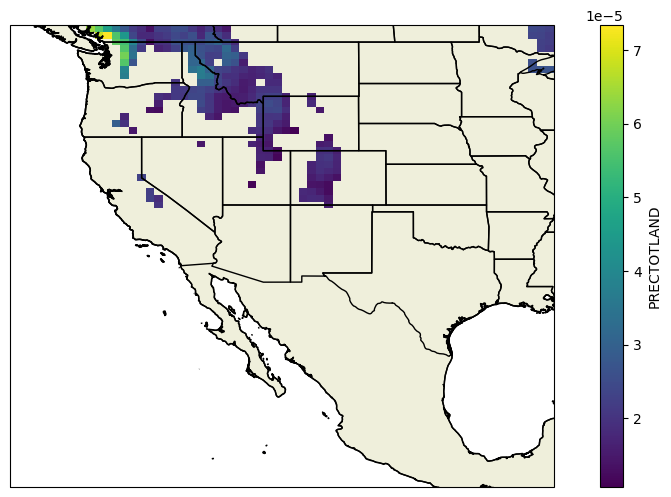

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())

ds_koppen.where(ds_koppen['koppen'] == 'Dc').PRECTOTLAND.mean(dim = 'time').plot(transform=ccrs.PlateCarree())

ax.coastlines('10m')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)


### Can't plot categorical variables directly so need to do some stuff 

Pulling from: 
Code from: https://github.com/stavrosl8/Koppen-Geiger-Climate-Classification-Map/blob/main/KG_classification.py

Full repo: https://github.com/stavrosl8/Koppen-Geiger-Climate-Classification-Map/tree/89619ee9dd9468262253b4c35d6055fe7bf1b2d9

In [22]:
ds

<xarray.Dataset>
Dimensions:      (time: 15919, bnds: 2, lat: 68, lon: 64)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01T12:00:00 ... 2023-08-01T12:...
  * lon          (lon) float64 -129.4 -128.8 -128.1 ... -91.25 -90.62 -90.0
  * lat          (lat) float64 16.5 17.0 17.5 18.0 18.5 ... 48.5 49.0 49.5 50.0
Dimensions without coordinates: bnds
Data variables: (12/13)
    time_bnds    (time, bnds, lat, lon) datetime64[ns] NaT ... 2023-08-01T23:...
    EVLAND       (time, lat, lon) float32 nan nan nan ... 3.482e-05 2.913e-05
    FRSNO        (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
    GWETROOT     (time, lat, lon) float32 nan nan nan ... 0.3093 0.3195 0.2904
    GWETTOP      (time, lat, lon) float32 nan nan nan nan ... 0.3959 0.42 0.4144
    PRECSNOLAND  (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
    ...           ...
    QINFIL       (time, lat, lon) float32 nan nan nan ... 9.621e-08 8.489e-08
    RUNOFF       (time, lat, lon) float32 nan nan nan ... 1.307e-08 1.707e-08
    RZMC         (time, lat, lon) float32 nan nan nan ... 0.1296 0.1338 0.1217
    SFMC         (time, lat, lon) float32 nan nan nan ... 0.1659 0.176 0.1736
    SNODP        (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
    TSURF        (time, lat, lon) float32 nan nan nan nan ... 292.3 291.8 292.0
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 17...
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Filename:                          MERRA2_100.tavg1_2d_lnd_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [95]:
koppen_classes_14 = {'Af': 1, 'Am':2, 'Aw': 3, 'BS': 4, 'BW': 5, 'Cs': 6, 'Cfa': 7, 'Cfb': 8, 
                     'Cfc': 9, 'Cw': 10, 'Dab': 11, 'Dc': 12, 'Et': 13, 'Ef': 14}

koppen_classes_14_long_names = {'Af': 'Tropical wet', 'Am': 'Tropical moist', 'Aw': 'Tropical Dry', 'BS': 'Semiarid', 'BW': 'Desert', 
                                'Cs': 'Temperate winter wet', 'Cfa': 'Hot temperate moist', 'Cfb' : 'Warm temperate moist', 'Cfc': 'Cool temperate moist', 
                                'Cw': 'Temperate summer wet', 'Dab': 'Cold winters/warm summers', 'Dc': 'Cold winters/cool summers', 'Et': 'Tundra', 'Ef' : 'Polar desert'}

koppen_classes_14_long_names_plus = {'Af': 'Tropical wet (Af)', 'Am': 'Tropical moist (Am)', 'Aw': 'Tropical Dry (Aw)', 'BS': 'Semiarid (BS)', 'BW': 'Desert (BW)', 
                                'Cs': 'Temperate winter wet (Cs)', 'Cfa': 'Hot temperate moist (Cfa)', 'Cfb' : 'Warm temperate moist (Cfb)', 'Cfc': 'Cool temperate moist (Cfc)', 
                                'Cw': 'Temperate summer wet (Cw)', 'Dab': 'Cold winters/warm summers (Dab)', 'Dc': 'Cold winters/cool summers (Dc)', 'Et': 'Tundra (Et)', 'Ef' : 'Polar desert (Ef)'}

colors_14 = ("#960000", "#FF0000", "#FFCCCC", "#CCAA54", 
             "#FFFF64", '#AAFF32', '#003200', '#005000', 
             '#007800', '#D2691E', '#820082', '#C800C8', 
             '#64FFFF', '#6496FF')

bounds = np.arange(1,15,1)


df_koppen = ds_koppen['koppen'].to_dataframe().dropna().reset_index()
df_koppen['koppen_number'] = df_koppen['koppen'].replace(koppen_classes_14)

lat = df_koppen['lat'].to_numpy() ; lon = df_koppen['lon'].to_numpy()
variable = df_koppen['koppen_number'].to_numpy()
arrays = [lat, lon] ; tuples = list(zip(*arrays))

index = pd.MultiIndex.from_tuples(tuples, names=['lat', 'lon'])
df_merged = pd.DataFrame(data = variable, columns= ["koppen_cls"], index = index)

ds_koppen_merged = df_merged['koppen_cls'].to_xarray()

ds_koppen['koppen_cls_num'] = ds_koppen_merged

cmap = mpl.colors.ListedColormap(colors_14)

#bounds_ticks = np.array(list((koppen_classes_14.keys())))
#bounds_ticks = np.array(list((koppen_classes_14_long_names.values())))
bounds_ticks = np.array(list((koppen_classes_14_long_names_plus.values())))

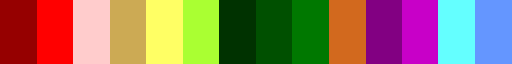

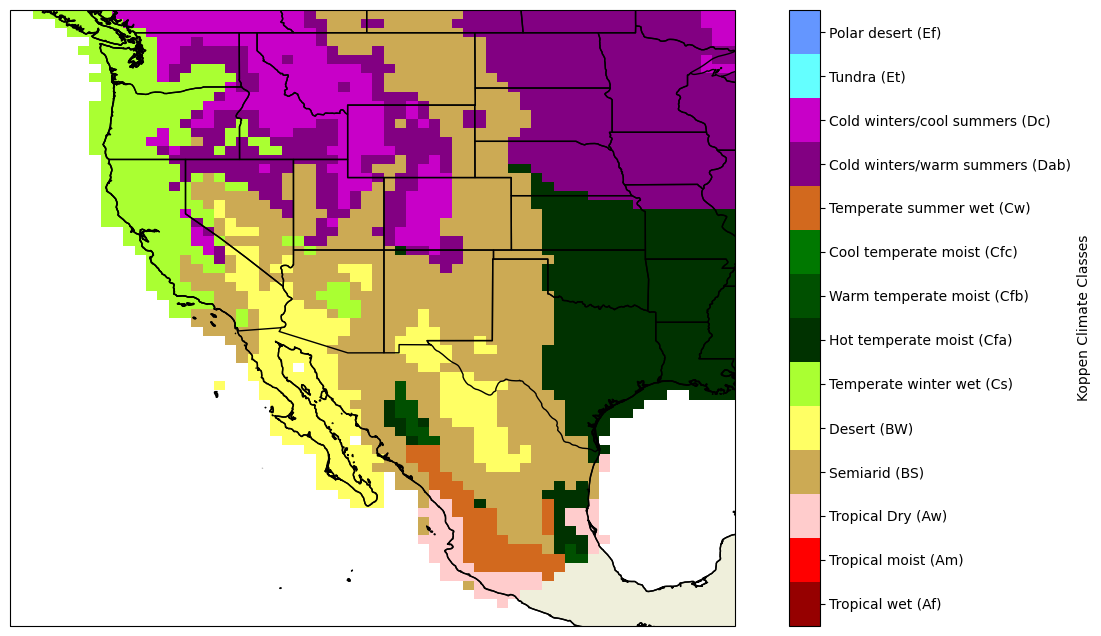

In [96]:
fig, ax = plt.subplots(figsize = (14,8), subplot_kw={"projection": ccrs.PlateCarree()})

cbar_kwargs = {"spacing": "proportional",'shrink':0.7,'pad':0.05,
               'orientation': 'vertical','label': 'Koppen Climate Classes'}

cax = ds_koppen['koppen_cls_num'].plot(cmap=cmap, transform=ccrs.PlateCarree(), ax = ax, 
                                       vmin= bounds[0] - .5, vmax=bounds[-1] + .5, add_colorbar = False)#,
                                       #cbar_kwargs=cbar_kwargs)

ax.coastlines('10m')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

cbar = fig.colorbar(cax, label = 'Koppen Climate Classes')
cbar.set_ticks(bounds)
cbar.set_ticklabels(bounds_ticks)

cmap

### Tidy up the file to export for faster use later

In [42]:
ds_test = ds_koppen.copy()

In [53]:
ds_concat = xr.concat([ds_test.where(ds_test['koppen'] == k) for k in koppen_classes_14.keys()],
           dim = pd.Index([k for k in koppen_classes_14.keys()], name = 'koppen_class'))

In [54]:
ds_clean = ds_concat.drop_vars(['koppen', 'koppen_cls_num'])

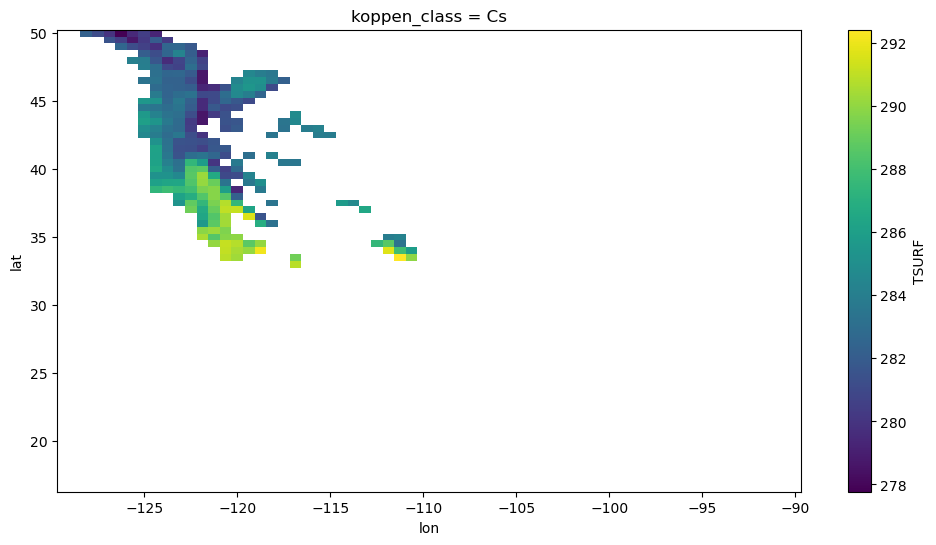

In [76]:
ds_clean.sel(koppen_class = 'Cs').mean(dim = 'time').TSURF.plot()

In [77]:
save_prefix = "~/Documents/02_academia/02_PhD/research/projects/precip-MERRA2/exported_data"

In [86]:
ds_clean = ds_clean.drop('time_bnds')

In [89]:
%time ds_clean.to_netcdf(save_prefix + '/WNA_CNA_SNA_MERRA2_land_koppen.nc')

CPU times: user 141 ms, sys: 40.6 s, total: 40.8 s
Wall time: 1min 41s


In [90]:
%time open_test = xr.open_mfdataset(save_prefix + '/WNA_CNA_SNA_MERRA2_land_koppen.nc')

CPU times: user 14.6 ms, sys: 9.68 ms, total: 24.3 ms
Wall time: 57.2 ms


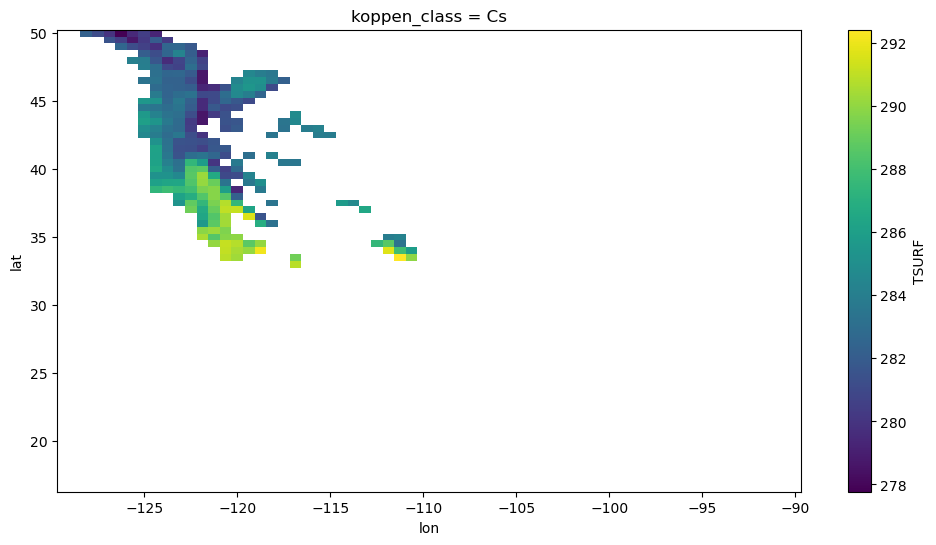

In [91]:
open_test.sel(koppen_class = 'Cs').mean(dim = 'time').TSURF.plot()

In [ ]:
open_test

<xarray.Dataset>
Dimensions:       (koppen_class: 14, time: 15919, bnds: 2, lat: 68, lon: 64)
Coordinates:
  * lat           (lat) float64 16.5 17.0 17.5 18.0 18.5 ... 48.5 49.0 49.5 50.0
  * lon           (lon) float64 -129.4 -128.8 -128.1 ... -91.25 -90.62 -90.0
  * time          (time) datetime64[ns] 1980-01-01T12:00:00 ... 2023-08-01T12...
  * koppen_class  (koppen_class) object 'Af' 'Am' 'Aw' 'BS' ... 'Dc' 'Et' 'Ef'
Dimensions without coordinates: bnds
Data variables: (12/13)
    time_bnds     (koppen_class, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(14, 15919, 2, 68, 64), meta=np.ndarray>
    EVLAND        (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    FRSNO         (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    GWETROOT      (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    GWETTOP       (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    PRECSNOLAND   (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    ...            ...
    QINFIL        (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    RUNOFF        (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    RZMC          (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    SFMC          (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    SNODP         (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
    TSURF         (koppen_class, time, lat, lon) float32 dask.array<chunksize=(14, 15919, 68, 64), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat May 31 17...
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Filename:                          MERRA2_100.tavg1_2d_lnd_Nx.19800101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                1980-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   1980-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [ ]:
ds_clean

In [35]:
#ds_test.set_coords(['koppen', 'koppen_cls_num'])

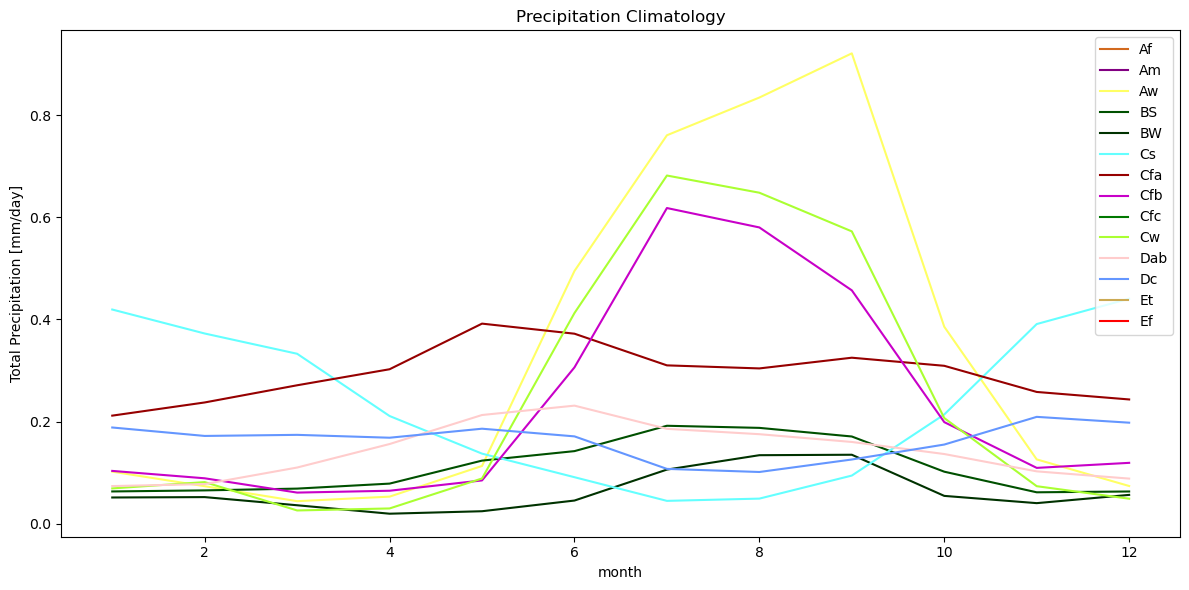

In [ ]:
for key, color in zip(koppen_classes_14.keys(), colors_14):
    global_mean(ds_koppen.where(ds_koppen['koppen'] == key).groupby('time.month').mean().PRECTOTLAND * 8640).plot(label = key, color = color)

plt.ylabel('Total Precipitation [mm/day]')    
plt.legend()
plt.title('Precipitation Climatology')
plt.tight_layout()
plt.show()

for key, color in zip(koppen_classes_14.keys(), colors_14):
    global_mean(ds_koppen.where(ds_koppen['koppen'] == key).groupby('time.month').mean().RUNOFF).plot(label = key, color = color)
    
plt.ylabel('Runoff [mm/day]')    
plt.legend()
plt.title('Runoff Climatology')
plt.tight_layout()
plt.show()

for key, color in zip(koppen_classes_14.keys(), colors_14):
    global_mean(ds_koppen.where(ds_koppen['koppen'] == key).groupby('time.month').mean().GWETTOP).plot(label = key, color = color)
    
plt.ylabel('Rootzone Soil Moisture')    
plt.legend()
plt.title('Rootzone Climatology')
plt.tight_layout()
plt.show()

for key, color in zip(koppen_classes_14.keys(), colors_14):
    global_mean(ds_koppen.where(ds_koppen['koppen'] == key).groupby('time.month').mean().GWETROOT).plot(label = key, color = color)
    
plt.ylabel('Surface Soil Moisture')    
plt.legend()
plt.title('Surface Soil Climatology')
plt.tight_layout()
plt.show()

calculate aggregate metrics, see how much variance between spatially different regimes - composites
start with Cs and BS

make seasonal plots of each class


how to compress hydrological variables into something readable and understandable
- and here is how those things are changing 
- 



### Composite

In [252]:
def composite_means(keyDates, ds, variable, days = range(-29,30)):
    '''
    keyDates: pandas dataframe of event dates 
    ds: xarray dataset of variable (variable composited against the event variable)
    months: range of months relative to the event of interest
    '''

    composite_means = xr.Dataset(data_vars = None, 
                       coords = {'relative_day': days},
                       attrs=None)
    means = []
    empty_means = np.empty((1, len(days)))
    empty_means[:] = np.nan
    
    standard_errors = []
    empty_errors = empty_means
    
    try: 
        for n in days:
            index = [(date + np.timedelta64(n, 'D')) for date in keyDates] 

            var_values_at_index = ds.sel(time = index, method ='nearest')[variable]

            means.append(float(var_values_at_index.mean()))

            standard_error = (var_values_at_index.std() / np.sqrt(len(var_values_at_index)))
            standard_errors.append(float(standard_error))

    except:
        print(len(keyDates))
        print('no keyDates')
        
    if len(means) == 0:
        means = empty_means[0]
        standard_errors = empty_errors[0]
        print('not enough events, replaced with NaNs') 
        

    composite_means = composite_means.assign({'means': (['relative_day'], means), 
                                              'errors':(['relative_day'], standard_errors)})
    
    return composite_means

def find_keyDates(ds, ds_qts, qt_1, qt_2, variable):
    '''
    find dates in dataset where the given variable is between the two given percentiles. 
    '''
    if qt_2 < 1:
        keyDates = ds.where(ds[variable] > ds_qts[variable].sel(quantile = qt_1), 
                 drop = True).where(ds[variable] < ds_qts[variable].sel(quantile = qt_2), drop = True)
    else:
        keyDates = ds.where(ds[variable] > ds_qts[variable].sel(quantile = qt_1), drop = True)
    
    return keyDates

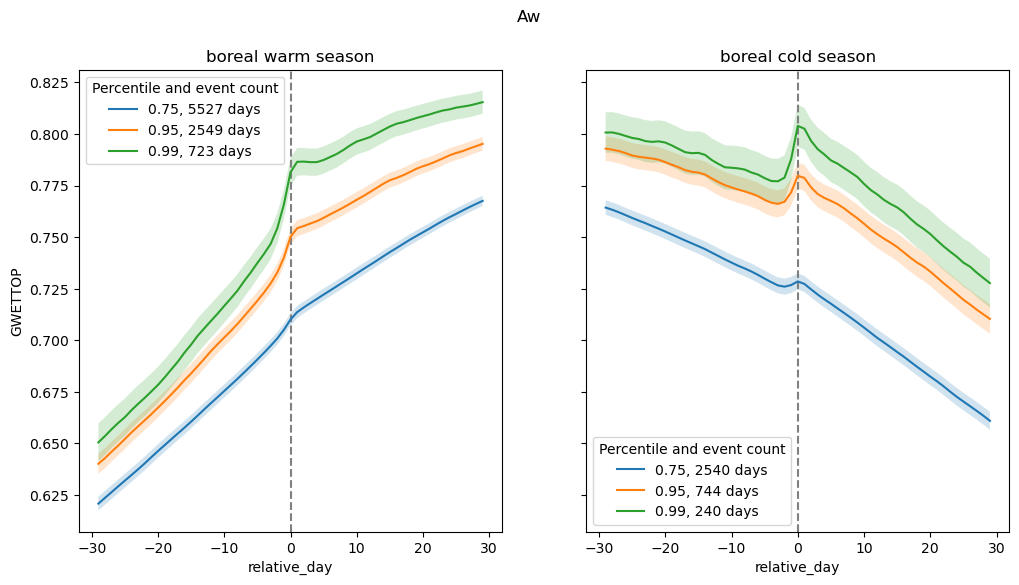

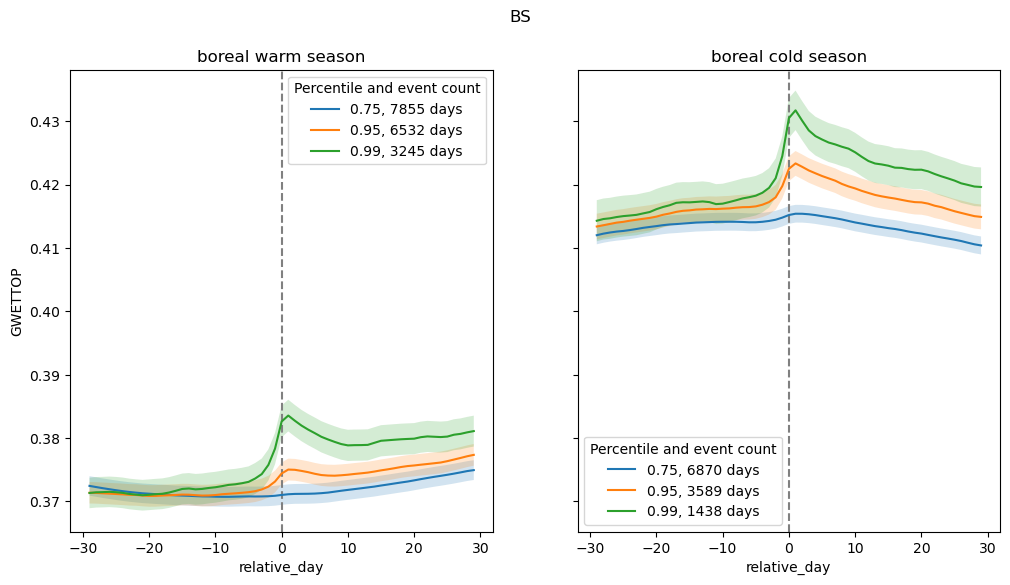

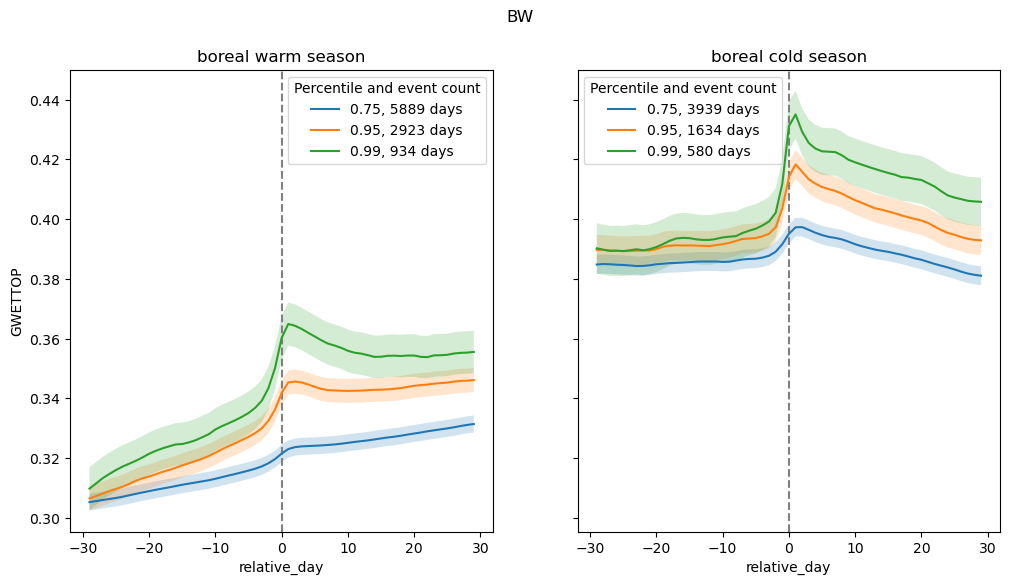

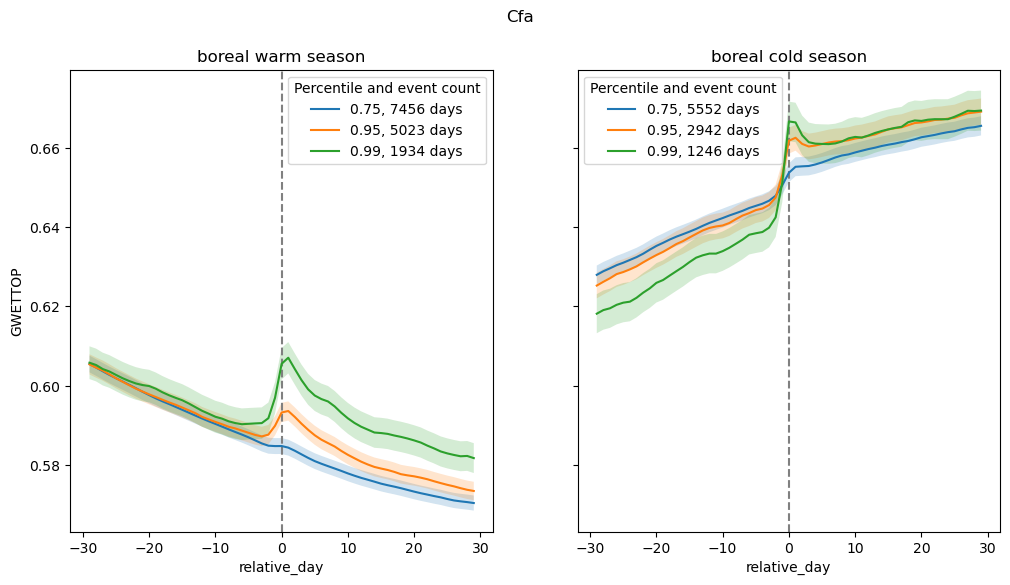

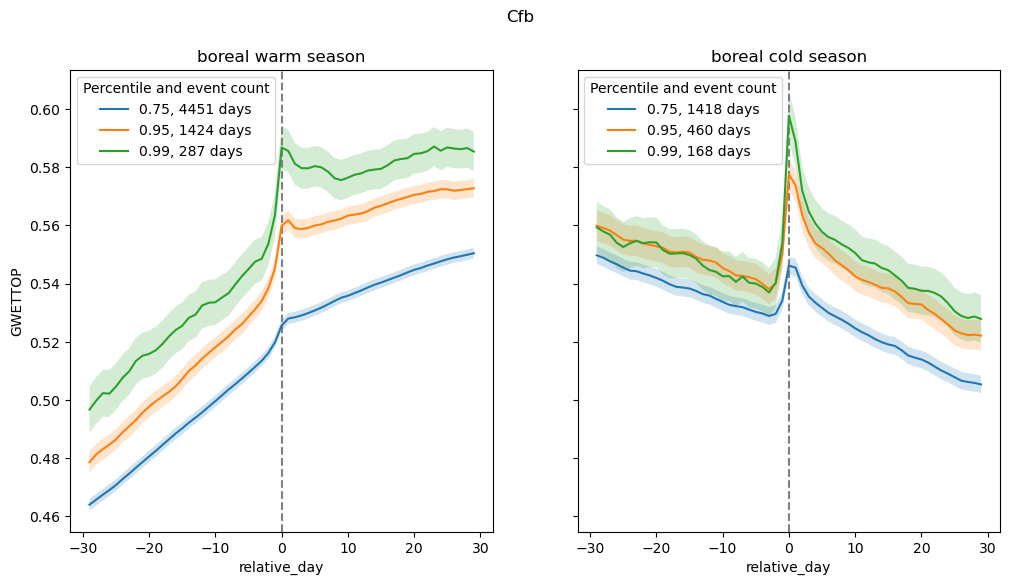

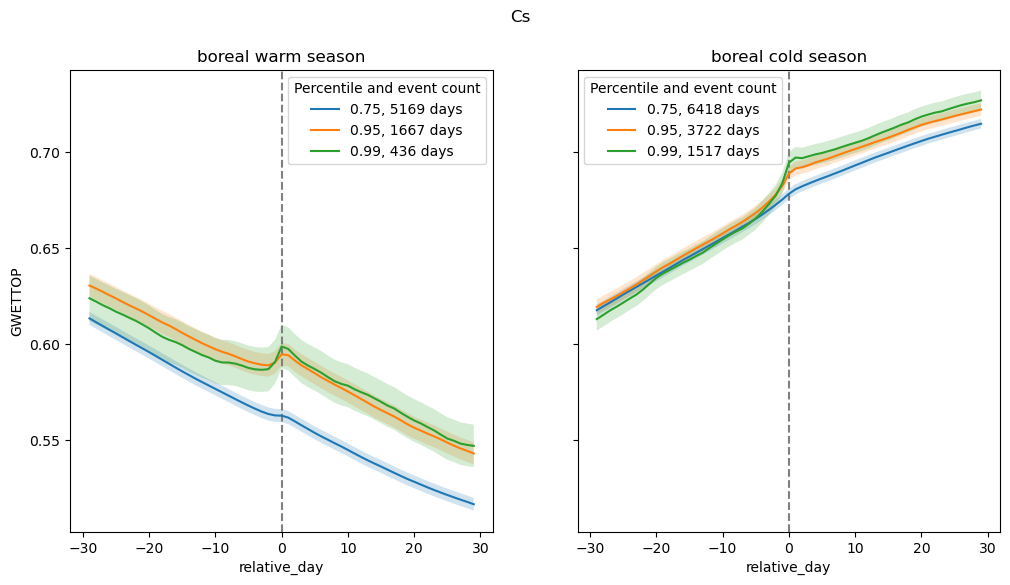

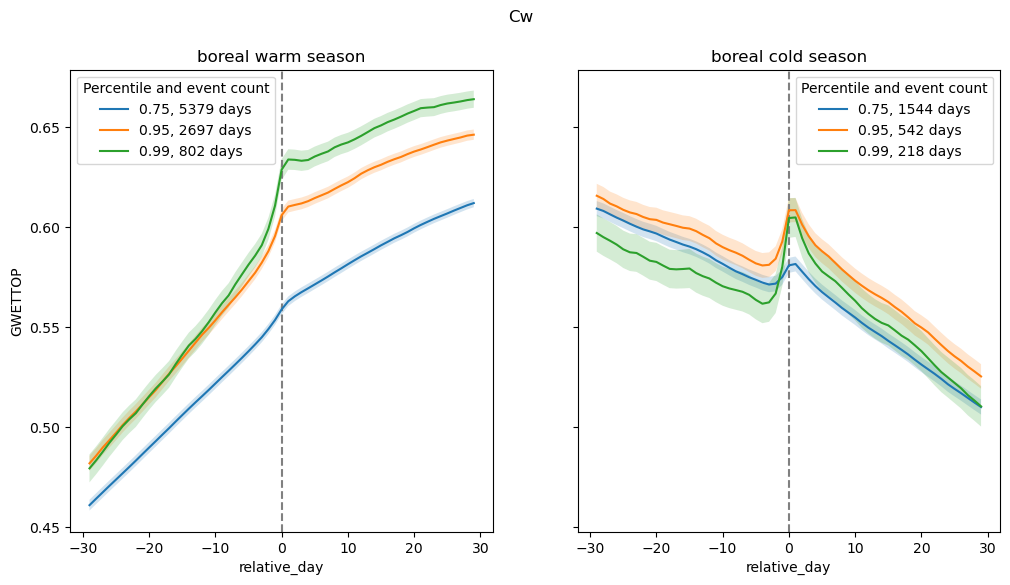

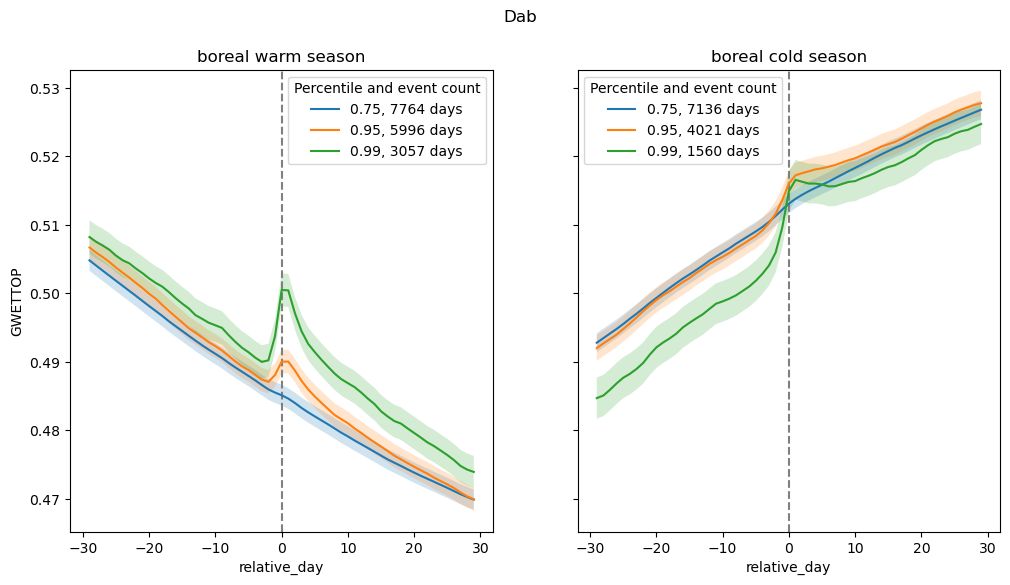

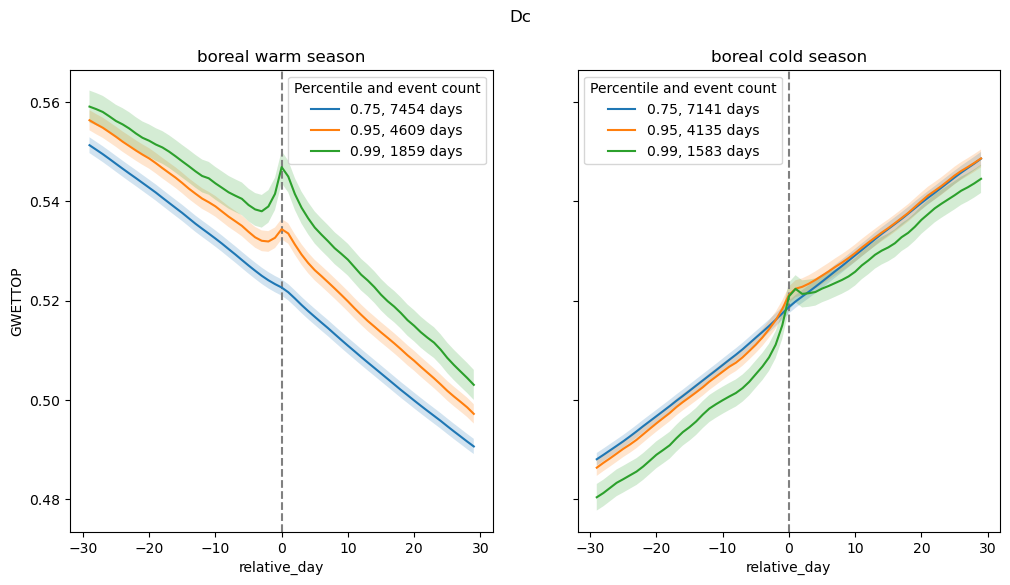

In [295]:
comparison_var = 'GWETTOP'
event_var = 'PRECTOTLAND'

boreal_cold = [10, 11, 12, 1, 2, 3]  #October - March
boreal_warm = [4, 5, 6, 7, 8, 9]     #April - September

seasons = [boreal_warm, boreal_cold]

#ds_koppen_grouped = ds_koppen.groupby(ds_koppen.koppen).mean()
found_classes = ds_koppen.groupby(ds_koppen.koppen).mean().koppen.data

for koppen_class in found_classes:
    ds_koppen_class = ds.where(ds_koppen.koppen == koppen_class, drop = True)
    ds_koppen_class_qt = ds_koppen_class.where(ds_koppen.PRECTOTLAND > qt_low_threshold, drop = True).quantile(qt_values, dim = qt_dims)

    fig, axarr = plt.subplots(ncols = 2, sharey = True)
    count_dates = dict()

    for season, ax in zip(seasons, axarr.flat):
        ax.axvline(x = 0, color = 'grey', linestyle = '--')

        for qt, color in zip(qt_values, ['orange', 'red', 'purple']):

            if qt <= 0.95:
                keyDates = find_keyDates(ds_koppen_class, ds_koppen_class_qt, qt, qt_values[qt_values.index(qt) + 1], event_var)
                keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

            else:
                keyDates = find_keyDates(ds_koppen_class, ds_koppen_class_qt, qt, 1, event_var)
                keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

            count_dates[qt] = len(keyDates)

            means = composite_means(keyDates, ds_koppen_class, comparison_var)
            means.means.plot(label = str(qt) + ', ' + str(count_dates[qt]) + ' days', ax = ax)
            ax.fill_between(means.relative_day, (means.means + means.errors), (means.means - means.errors), alpha = 0.2)


            ax.set_ylabel(None)

            if season == boreal_warm:
                season_title = 'boreal warm'
            if season == boreal_cold:
                season_title = 'boreal cold'
            ax.set_title(season_title + ' season')
            ax.legend(title = 'Percentile and event count')

        axarr[0].set_ylabel(comparison_var)
        plt.suptitle(koppen_class)

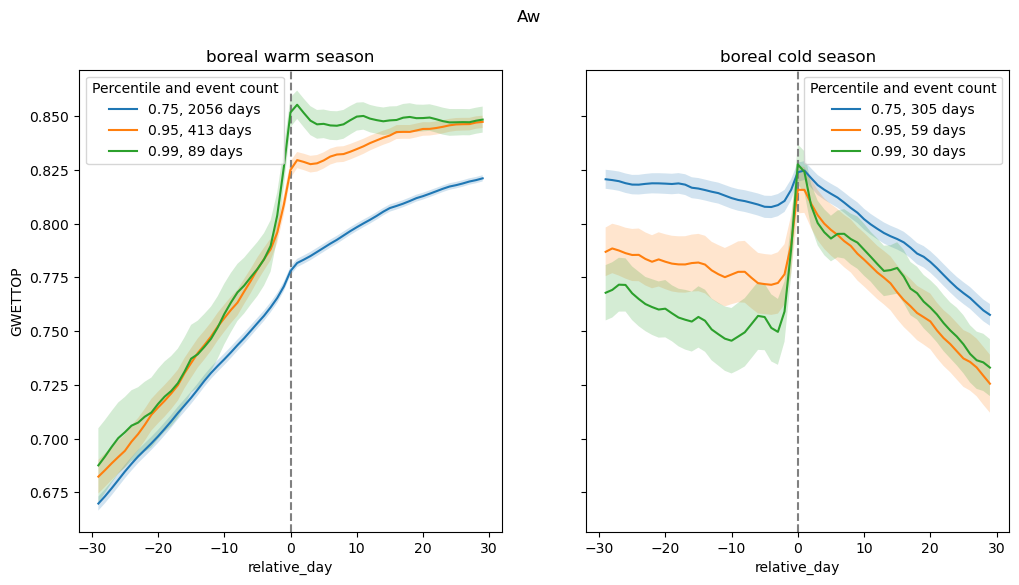

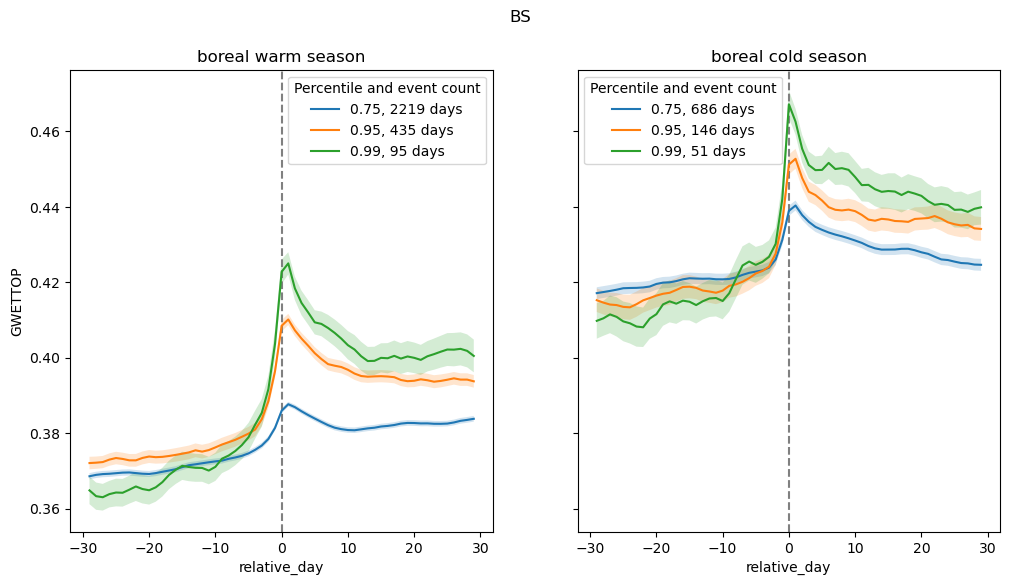

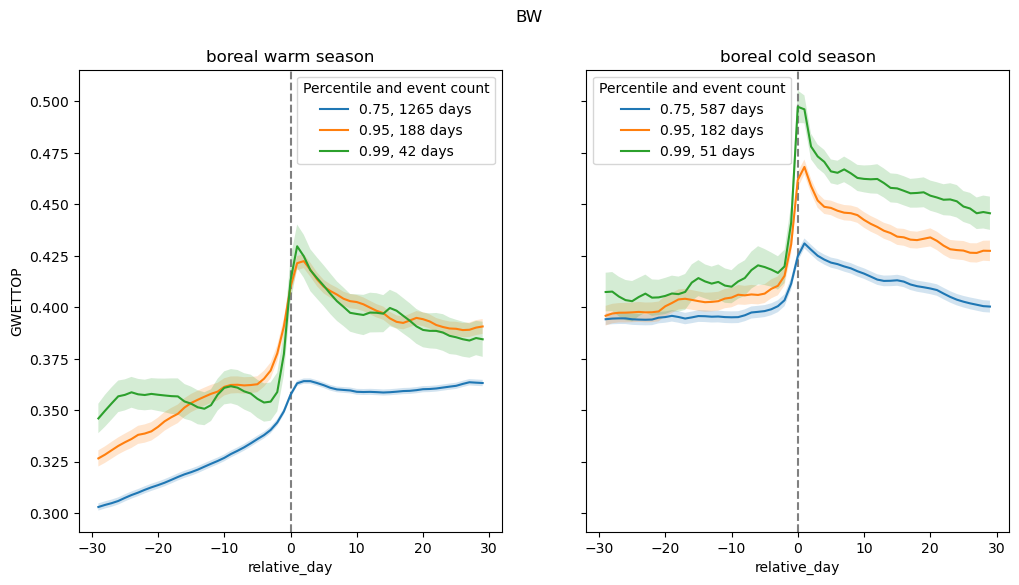

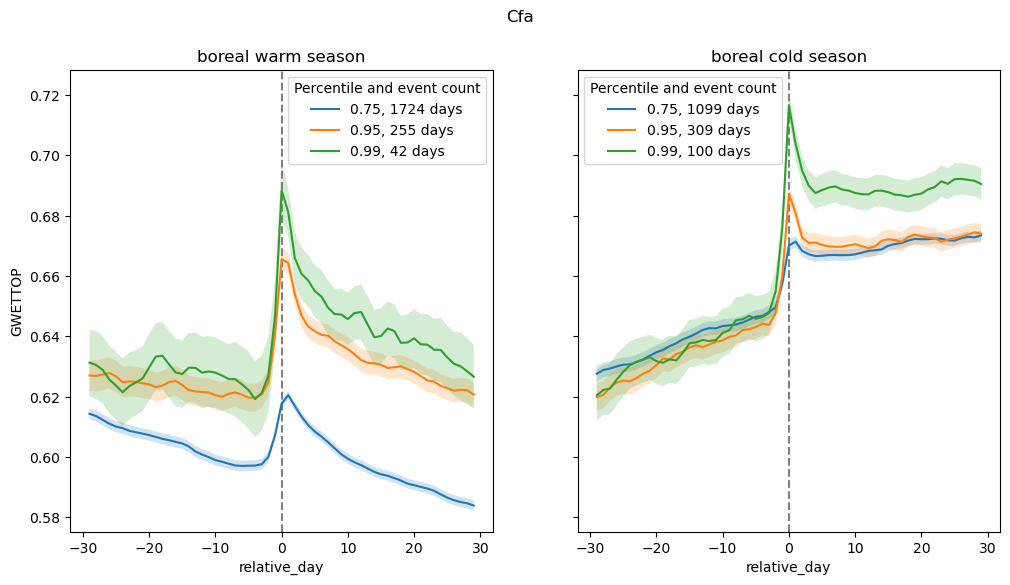

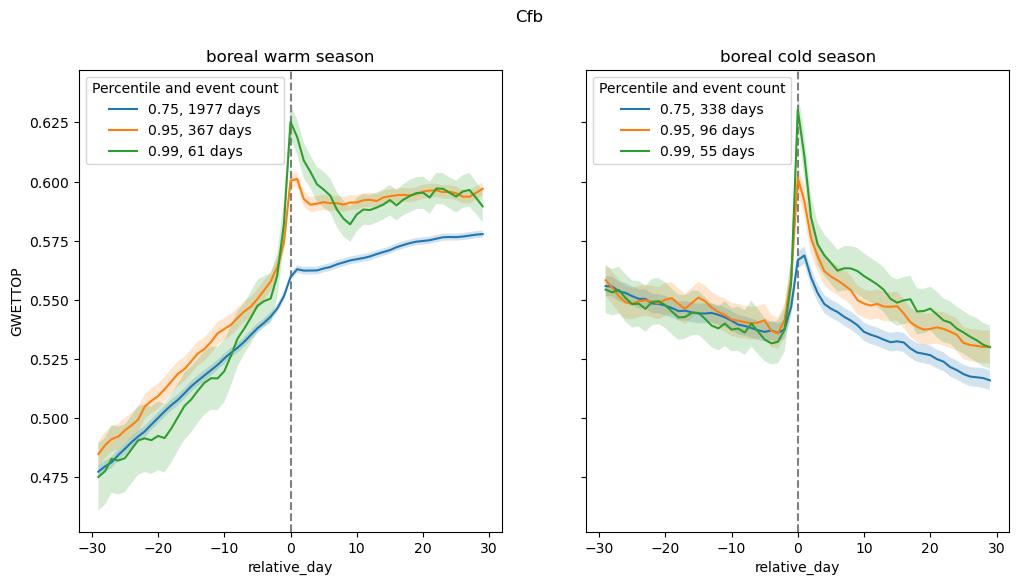

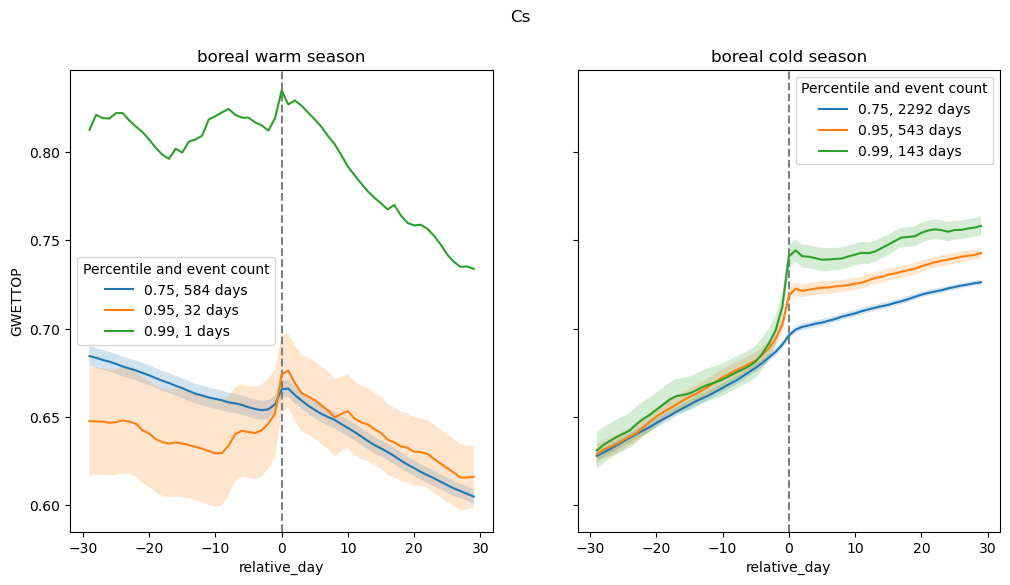

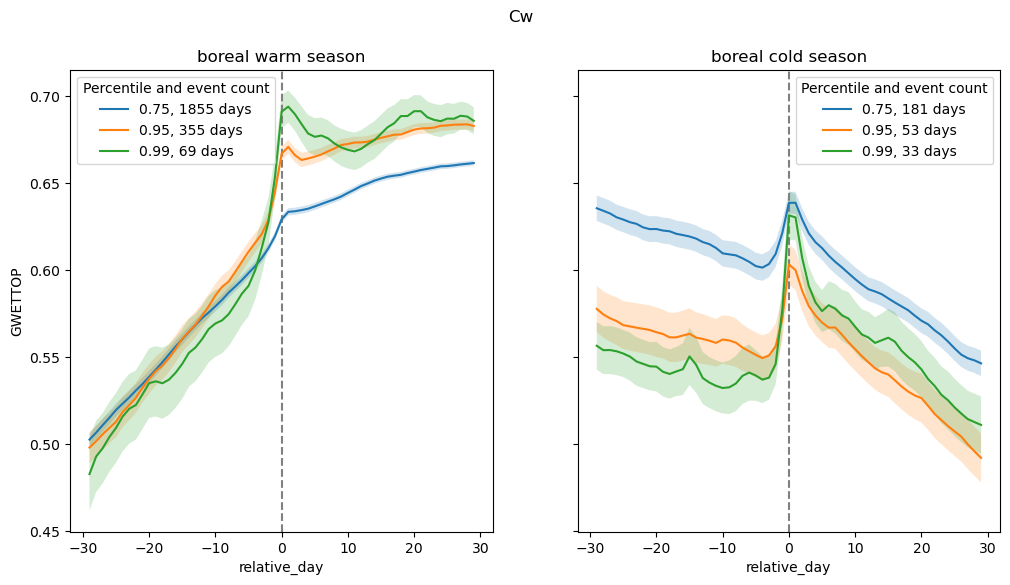

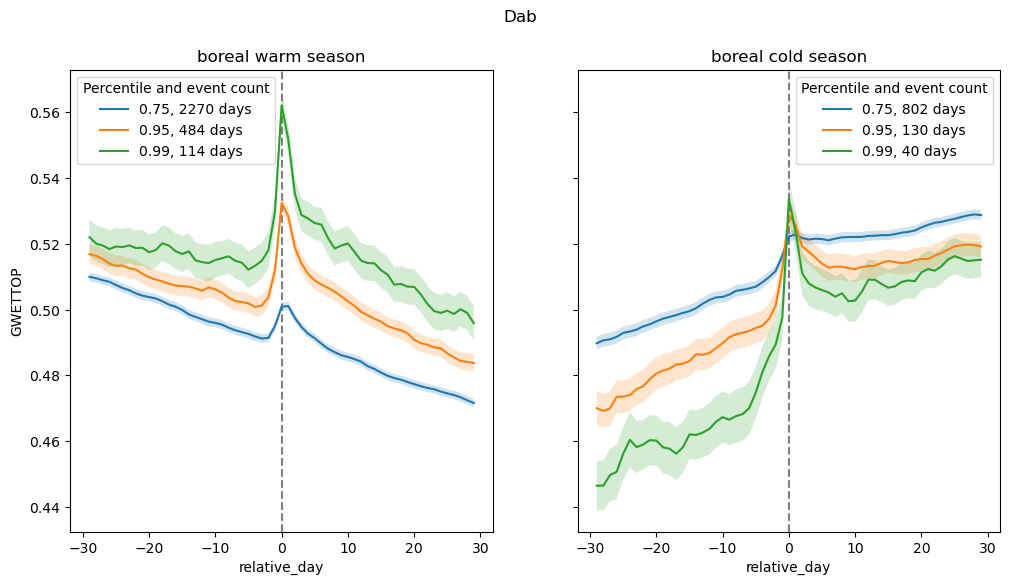

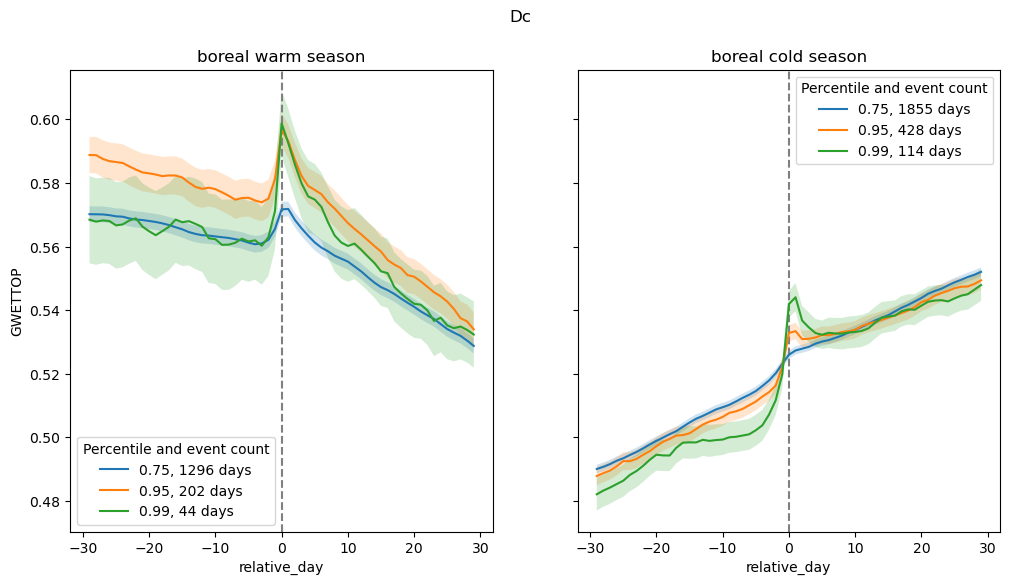

In [304]:
comparison_var = 'GWETTOP'
event_var = 'PRECTOTLAND'

boreal_cold = [10, 11, 12, 1, 2, 3]  #October - March
boreal_warm = [4, 5, 6, 7, 8, 9]     #April - September

seasons = [boreal_warm, boreal_cold]

ds_koppen_grouped = ds_koppen.groupby(ds_koppen.koppen).mean()
found_classes = ds_koppen.groupby(ds_koppen.koppen).mean().koppen.data

for koppen_class in found_classes:

    ds_koppen_class = ds_koppen_grouped.sel(koppen = koppen_class)    
    ds_koppen_class_qt = ds_koppen_class.where(ds_koppen_class.PRECTOTLAND > qt_low_threshold, drop = True).quantile(qt_values, dim = qt_dims)


    fig, axarr = plt.subplots(ncols = 2, sharey = True)
    count_dates = dict()

    for season, ax in zip(seasons, axarr.flat):
        ax.axvline(x = 0, color = 'grey', linestyle = '--')

        for qt, color in zip(qt_values, ['orange', 'red', 'purple']):

            if qt <= 0.95:
                keyDates = find_keyDates(ds_koppen_class, ds_koppen_class_qt, qt, qt_values[qt_values.index(qt) + 1], event_var)
                keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

            else:
                keyDates = find_keyDates(ds_koppen_class, ds_koppen_class_qt, qt, 1, event_var)
                keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

            count_dates[qt] = len(keyDates)

            means = composite_means(keyDates, ds_koppen_class, comparison_var)
            means.means.plot(label = str(qt) + ', ' + str(count_dates[qt]) + ' days', ax = ax)
            ax.fill_between(means.relative_day, (means.means + means.errors), (means.means - means.errors), alpha = 0.2)


            ax.set_ylabel(None)

            if season == boreal_warm:
                season_title = 'boreal warm'
            if season == boreal_cold:
                season_title = 'boreal cold'
            ax.set_title(season_title + ' season')
            ax.legend(title = 'Percentile and event count')

        axarr[0].set_ylabel(comparison_var)
        plt.suptitle(koppen_class)

In [294]:
qt_low_threshold = 0.000001 #0.000000001 #kg m-2 s-1
qt_dims = ('time')
qt_values = [0.75, 0.95, 0.99]

koppen_class = 'Cs'

ds_koppen_class = ds.where(ds_koppen.koppen == koppen_class, drop = True)
ds_koppen_class_qt = ds_koppen_class.where(ds_koppen.PRECTOTLAND > qt_low_threshold, drop = True).quantile(qt_values, dim = qt_dims)

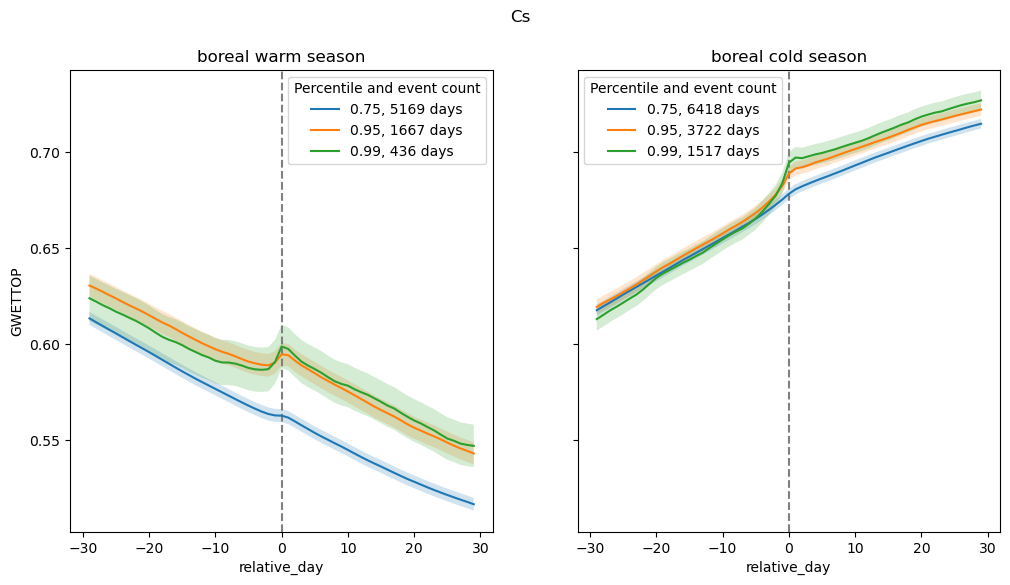

In [285]:
comparison_var = 'GWETTOP'
event_var = 'PRECTOTLAND'

boreal_cold = [10, 11, 12, 1, 2, 3]  #October - March
boreal_warm = [4, 5, 6, 7, 8, 9]     #April - September

seasons = [boreal_warm, boreal_cold]

fig, axarr = plt.subplots(ncols = 2, sharey = True)
count_dates = dict()

for season, ax in zip(seasons, axarr.flat):
    ax.axvline(x = 0, color = 'grey', linestyle = '--')

    for qt, color in zip(qt_values, ['orange', 'red', 'purple']):

        if qt <= 0.95:
            keyDates = find_keyDates(ds_koppen_class, ds_koppen_class_qt, qt, qt_values[qt_values.index(qt) + 1], event_var)
            keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

        else:
            keyDates = find_keyDates(ds_koppen_class, ds_koppen_class_qt, qt, 1, event_var)
            keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

        count_dates[qt] = len(keyDates)

        means = composite_means(keyDates, ds_koppen_class, comparison_var)
        means.means.plot(label = str(qt) + ', ' + str(count_dates[qt]) + ' days', ax = ax)
        ax.fill_between(means.relative_day, (means.means + means.errors), (means.means - means.errors), alpha = 0.2)


        ax.set_ylabel(None)

        if season == boreal_warm:
            season_title = 'boreal warm'
        if season == boreal_cold:
            season_title = 'boreal cold'
        ax.set_title(season_title + ' season')
        ax.legend(title = 'Percentile and event count')

    axarr[0].set_ylabel(comparison_var)
    plt.suptitle(koppen_class)

In [269]:
comparison_var = 'GWETTOP'
event_var = 'PRECTOTLAND'

boreal_cold = [10, 11, 12, 1, 2, 3]  #October - March
boreal_warm = [4, 5, 6, 7, 8, 9]     #April - September

seasons = [boreal_warm, boreal_cold]
#seasons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

regimes_ds = #ds.groupby(ds.regime).mean()
found_regimes = ds.groupby(ds.regime).mean().regime.data

for regime in regimes:
    fig, axarr = plt.subplots(ncols = 2, sharey = True)
    count_dates = dict()
    
    for season, ax in zip(seasons, axarr.flat):
        
        ax.axvline(x = 0, color = 'grey', linestyle = '--')
        
        for qt, color in zip(qt_values, ['orange', 'red', 'purple']):
            
            
            if qt <= 0.95:
                ### NEED TO MAKE THIS WORK + ADD NEW QUARTILES 
                keyDates = find_keyDates(regimes_ds.sel(regime = regime), dict_qt_regimes[regime], qt, qt_values[qt_values.index(qt) + 1], event_var)
                keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data
                
            else:
                keyDates = find_keyDates(regimes_ds.sel(regime = regime), dict_qt_regimes[regime], qt, 1, event_var)
                keyDates = keyDates.sel(time = keyDates.time.dt.month.isin([season])).time.data

            count_dates[qt] = len(keyDates)

            means = composite_means(keyDates, regimes_ds.sel(regime = regime), comparison_var)
            means.means.plot(label = str(qt) + ', ' + str(count_dates[qt]) + ' days', ax = ax)
            ax.fill_between(means.relative_day, (means.means + means.errors), (means.means - means.errors), alpha = 0.2)
    

    
        ax.set_ylabel(None)

        if season == boreal_warm:
            season_title = 'boreal warm'
        if season == boreal_cold:
            season_title = 'boreal cold'
        ax.set_title(season_title + ' season')
        ax.legend(title = 'Percentile and event count')

    axarr[0].set_ylabel(comparison_var)
    plt.suptitle(regime)

array(['1980-01-08T12:00:00.000000000', '1980-01-09T12:00:00.000000000',
       '1980-01-10T12:00:00.000000000', ...,
       '2023-05-05T12:00:00.000000000', '2023-05-07T12:00:00.000000000',
       '2023-06-09T12:00:00.000000000'], dtype='datetime64[ns]')

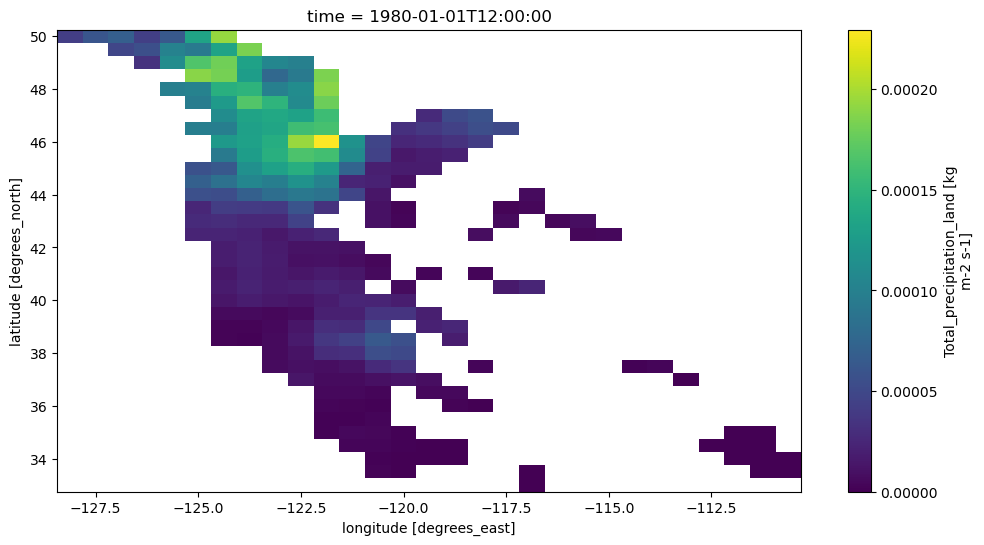

In [265]:
ds_Cs.sel(time = '1980-01-01').PRECTOTLAND.plot()

In [ ]:
# Class_replacement = {'Af':1,'Am':2,'As':3,'Aw':4,'BWk':5,'BWh':6,'BSk':7,'BSh':8,
#         'Cfa':9,'Cfb':10,'Cfc':11,'Csa':12,'Csb':13,'Csc':14,'Cwa':15,
#         'Cwb':16,'Cwc':17,'Dfa':18,'Dfb':19,'Dfc':20,'Dfd':21,'Dsa':22,
#         'Dsb':23,'Dsc':24,'Dsd':25,'Dwa':26,'Dwb':27,'Dwc':28,'Dwd':29,
#         'EF':30,'ET':31}

# colors = ["#960000","#FF0000","#FF6E6E","#FFCCCC","#FFFF64","#FFCC00",
#           "#CCAA54","#CC8D14","#003200","#005000","#007800","#AAFF32",
#           "#00D700","#96FF00","#D2691E","#A9561E","#653700","#550055",
#           "#820082","#C800C8","#FF6EFF","#646464","#8C8C8C","#BEBEBE",
#           "#E6E6E6","#6E28B4","#B464FA","#C89BFA","#C8C8FF","#6496FF",
#           "#64FFFF"]

# colors[Class_replacement['EF']-1]


In [411]:
df_koppen

,lat,lon,koppen,koppen_number
0,18.5,-104.375,BS,4
1,19.0,-100.000,Cfa,7
2,19.5,-103.750,Cfa,7
3,19.5,-103.125,Cfa,7
4,19.5,-102.500,Cfa,7
...,...,...,...,...
1481,50.0,-107.500,BS,4
1482,50.0,-106.875,BS,4
1483,50.0,-106.250,BS,4
1484,50.0,-105.625,BS,4


In [103]:
test_test = ds_test['koppen'].astype(object)

'Cs'

In [ ]:
ds.where(ds[t_var]

In [345]:
koppen_types = ['BW', 'BS', 'Cs', 'Cw', 'Cfa', 'Cfb', 'Cfc']

category_to_numeric = {category: i for i, category in enumerate(koppen_types)}
category_to_numeric

{'BW': 0, 'BS': 1, 'Cs': 2, 'Cw': 3, 'Cfa': 4, 'Cfb': 5, 'Cfc': 6}

In [352]:
np.vectorize(category_to_numeric.get)(ds_koppen['koppen'])[6]

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, 4, 4, 4, 4, 4, 4,
       6, 6, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None], dtype=object)

In [357]:
ds_koppen['koppen_numeric'] = xr.ones_like(ds_koppen[p_var].isel(time = 0))*np.nan


#ds_koppen['koppen_numeric'] = ([ds_koppen['koppen_numeric'].lat, ds_koppen['koppen_numeric'].lon], np.vectorize(category_to_numeric.get)(ds_koppen['koppen']))

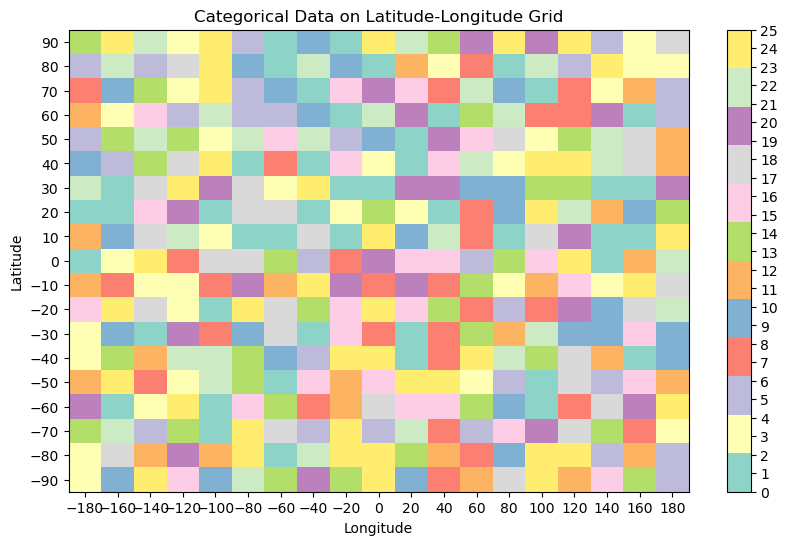

In [328]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Create sample data
lats = np.arange(-90, 91, 10)
lons = np.arange(-180, 181, 20)
data = np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), size=(len(lats), len(lons)))

# Create a mapping of letters to numeric values
unique_categories = np.unique(data)
category_to_numeric = {category: i for i, category in enumerate(unique_categories)}

# Convert data to numeric values using the mapping
numeric_data = np.vectorize(category_to_numeric.get)(data)

# Create an xarray DataArray
da = xr.DataArray(numeric_data, coords=[lats, lons], dims=['latitude', 'longitude'])

# Create a plot using matplotlib
plt.figure(figsize=(10, 6))
da.plot(x='longitude', y='latitude', cmap='Set3', vmin=0, vmax=len(unique_categories)-1, cbar_kwargs={'ticks': np.arange(len(unique_categories))})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Categorical Data on Latitude-Longitude Grid')
plt.xticks(lons)
plt.yticks(lats)
plt.show()

In [325]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Create sample data
lats = np.arange(-90, 91, 10)
lons = np.arange(-180, 181, 20)
data = np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), size=(len(lats), len(lons)))

# Create an xarray DataArray
da = xr.DataArray(data, coords=[lats, lons], dims=['latitude', 'longitude'])

# Create a plot using matplotlib
plt.figure(figsize=(10, 6))
da.plot(cmap='Set3', vmin=0, vmax=len(data)-1, cbar_kwargs={'ticks': np.arange(len(data))})
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Categorical Data on Latitude-Longitude Grid')
#plt.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 1000x600 with 0 Axes>

In [327]:
da.plot()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''